In [1]:
import os
import sys
import torch
import numpy as np
import matplotlib.pyplot as plt
import cv2
from scipy.spatial.distance import cdist
from deeplay import LodeSTAR
import deeptrack.deeplay as dl
import deeptrack as dt
import utils
from custom_lodestar import customLodeSTAR, OrientationAwareLodeSTAR

/opt/mona_jupyterhub_env/lib/python3.10/site-packages/deeptrack/__init__.py:13: UserWarning: TensorFlow is detected in your environment. DeepTrack2 version 2.0++ no longer supports TensorFlow. If you need TensorFlow support, please install the legacy version 1.7 of DeepTrack2:

    pip install deeptrack==1.7

For more details, refer to the DeepTrack documentation.
  warnings.warn(


In [2]:
def load_trained_model(checkpoint_path):
    """Load trained LodeSTAR model"""
    
    # Load configuration
    config = utils.load_yaml('config.yaml')
    
    # Create LodeSTAR model
    lodestar = OrientationAwareLodeSTAR(
            n_transforms=config['n_transforms'], 
            optimizer=dl.Adam(lr=config['lr'])
        ).build()
    
    # Load trained weights
    if os.path.exists(checkpoint_path):
        lodestar.load_state_dict(torch.load(checkpoint_path))
        print(f"Loaded model from {checkpoint_path}")
    else:
        print(f"Warning: Checkpoint not found at {checkpoint_path}")
        return None
    
    lodestar.eval()
    return lodestar


In [3]:
def cluster_nearby_detections(detections, distance_threshold=20, orientations=None):
    """
    Cluster nearby detections that likely belong to the same object.
    
    Parameters:
    -----------
    detections : np.ndarray
        Array of detections with shape (N, 2) where each row is [x, y]
    distance_threshold : float
        Maximum distance between detections to be considered the same object
    orientations : np.ndarray, optional
        Array of orientations with shape (N,) corresponding to detections
    
    Returns:
    --------
    np.ndarray
        Clustered detections with shape (M, 2) where M <= N
    np.ndarray or None
        Clustered orientations with shape (M,) if orientations provided, else None
    """
    if len(detections) <= 1:
        return detections, orientations if orientations is not None else None
    
    # Calculate pairwise distances
    distances = cdist(detections, detections)
    
    # Create clusters using a simple greedy approach
    clusters = []
    used = set()
    
    for i in range(len(detections)):
        if i in used:
            continue
        
        # Start a new cluster
        cluster = [i]
        used.add(i)
        
        # Find all nearby detections
        for j in range(i + 1, len(detections)):
            if j not in used and distances[i, j] <= distance_threshold:
                cluster.append(j)
                used.add(j)
        
        clusters.append(cluster)
    
    # Compute cluster centroids
    clustered_detections = []
    clustered_orientations = []
    
    for cluster in clusters:
        if len(cluster) == 1:
            # Single detection, keep as is
            clustered_detections.append(detections[cluster[0]])
            if orientations is not None:
                clustered_orientations.append(orientations[cluster[0]])
        else:
            # Multiple detections, compute centroid
            centroid = np.mean(detections[cluster], axis=0)
            clustered_detections.append(centroid)
            if orientations is not None:
                cluster_orientations = orientations[cluster]
                mean_orientation = np.mean(cluster_orientations)
                clustered_orientations.append(mean_orientation)
    
    result_orientations = np.array(clustered_orientations) if orientations is not None else None
    return np.array(clustered_detections), result_orientations


def detect_particles(model, image, config, particle_type=None):
    """Detect particles using trained LodeSTAR model"""
    
    # Convert image to numpy array if it's not already
    if not isinstance(image, np.ndarray):
        image = np.array(image)
    
    # Ensure image is 2D grayscale
    if len(image.shape) == 3:
        if image.shape[-1] == 3:  # RGB image (H, W, 3)
            image = np.dot(image[..., :3], [0.299, 0.587, 0.114])
        elif image.shape[0] == 3:  # RGB image (3, H, W)
            image = np.dot(image[:3].transpose(1, 2, 0), [0.299, 0.587, 0.114])
        elif image.shape[-1] == 1:  # Single channel (H, W, 1)
            image = image[..., 0]
        elif image.shape[0] == 1:  # Single channel (1, H, W)
            image = image[0]
        else:
            image = image[0] if image.shape[0] < image.shape[-1] else image[..., 0]
    elif len(image.shape) > 3:
        if image.shape[1] == 3:  # (B, 3, H, W)
            image = np.dot(image[0].transpose(1, 2, 0), [0.299, 0.587, 0.114])
        else:
            image = image[0, 0] if len(image.shape) == 4 else image[0]
    
    if len(image.shape) != 2:
        raise ValueError(f"Image must be 2D after processing, got shape {image.shape}")
    
    # Prepare image for model: (H, W) -> (1, 1, H, W)
    image_tensor = torch.from_numpy(image).unsqueeze(0).unsqueeze(0).float()
    
    # Get prediction from model
    with torch.no_grad():
        model_output = model(image_tensor)
        
        # Extract weights tensor (last channel)
        if len(model_output.shape) == 4 and model_output.shape[1] >= 3:
            weights = model_output[0, -1].detach().numpy()
            prediction = {'weights': weights}
        else:
            prediction = model_output[0].detach().numpy() if len(model_output.shape) == 4 else model_output.detach().numpy()
    
    # Scale weights tensor if needed
    h, w = image.shape
    if isinstance(prediction, dict) and 'weights' in prediction:
        weights_tensor = prediction['weights']
        if weights_tensor.shape != (h, w):
            prediction['weights'] = cv2.resize(weights_tensor, (w, h), interpolation=cv2.INTER_LINEAR)
    elif isinstance(prediction, np.ndarray) and prediction.shape[:2] != (h, w):
        if len(prediction.shape) == 3:
            scaled_prediction = np.zeros((prediction.shape[0], h, w))
            for c in range(prediction.shape[0]):
                scaled_prediction[c] = cv2.resize(prediction[c], (w, h), interpolation=cv2.INTER_LINEAR)
            prediction = scaled_prediction
        else:
            prediction = cv2.resize(prediction, (w, h), interpolation=cv2.INTER_LINEAR)
    
    # Get detections using model's detect method
    detection_orientations = None
    try:
        detections = model.detect(
            image_tensor, 
            alpha=0.8, #config.get('alpha', 0.2), 
            beta=0.2, #config.get('beta', 0.8), 
            mode=config.get('mode', "constant"), 
            cutoff=0.1,#config.get('cutoff', 0.2),
            particle_type=particle_type,
            compute_center=False
        )[0]
        
        if len(detections) > 0:
            # Swap coordinates: [y, x] -> [x, y] and cluster
            detections_xy = detections[:, [1, 0]] if detections.shape[1] >= 2 else detections
            
            # Extract orientations if available (3rd column or beyond)
            original_orientations = None
            if detections.shape[1] > 2:
                original_orientations = detections[:, 2] if detections.shape[1] >= 3 else None
            
            clustered_detections, detection_orientations = cluster_nearby_detections(
                detections_xy, distance_threshold=20, orientations=original_orientations
            )
            
            detections_with_confidence = np.column_stack([clustered_detections, np.ones(len(clustered_detections))])
            detection_labels = [particle_type] * len(clustered_detections) if particle_type else None
        else:
            detections_with_confidence = np.empty((0, 3))
            detection_labels = []
    except AttributeError as e:
        print(f"AttributeError: detect method doesn't exist: {e}")
        detections_with_confidence = np.empty((0, 3))
        detection_labels = []
    
    return detections_with_confidence, prediction, detection_labels, model_output, detection_orientations

In [4]:
def visualize_detection_results(image, gt_bboxes, detections, prediction, title="Detection Results", snr=None, gt_labels=None, detection_labels=None, metrics=None, model_output=None, gt_orientations=None, detection_orientations=None):
    """Visualize detection results with ground truth and predictions"""
    
    # Create figure with equal-sized subplots
    fig, axes = plt.subplots(1, 2, figsize=(20, 10), subplot_kw={'aspect': 'equal'})
      
    # Weighted prediction visualization
    if model_output is not None and isinstance(prediction, dict) and 'weights' in prediction:
        try:
            if len(model_output.shape) == 4 and model_output.shape[1] >= 3:
                rho = model_output[0, -1].detach().cpu().numpy()
                rho_normalized = (rho - rho.min()) / (rho.max() - rho.min() + 1e-8)
                axes[0].imshow(rho_normalized, cmap='hot', aspect='equal')
                axes[0].set_title("Prediction (Weight Map)")
            else:
                axes[0].imshow(image, cmap='gray')
                axes[0].set_title("Prediction: N/A")
        except Exception as e:
            print(f"Error plotting weighted predictions: {e}")
            axes[0].imshow(image, cmap='gray')
            axes[0].set_title("Prediction: Error")
    else:
        axes[0].imshow(image, cmap='gray')
        axes[0].set_title("Prediction: N/A")
    #axes[0].axis('off')
    
    # Combined results
    axes[1].imshow(image, cmap='gray')
    
    # Plot ground truth
    if len(gt_bboxes) > 0:
        for i, (x, y) in enumerate(gt_bboxes):
            label = gt_labels[i] if gt_labels and i < len(gt_labels) else 'Unknown'
            axes[1].plot(x, y, 'go', markersize=5, markeredgecolor='white', markeredgewidth=1, label=f'GT: {label}' if i == 0 else "")
            
            if gt_orientations and i < len(gt_orientations):
                orientation = gt_orientations[i] * 2 * np.pi
                arrow_length = 15
                dx = arrow_length * np.cos(orientation)
                dy = -arrow_length * np.sin(orientation)
                axes[1].arrow(x, y, dx, dy, head_width=3, head_length=2, fc='green', ec='green', alpha=0.7)
    
    # Plot detections
    if len(detections) > 0:
        for i, (x, y, conf) in enumerate(detections):
            label = detection_labels[i] if detection_labels and i < len(detection_labels) else 'Unknown'
            axes[1].plot(x, y, 'ro', markersize=5, markeredgecolor='white', markeredgewidth=1, label=f'Det: {label}' if i == 0 else "")
            
            if detection_orientations is not None and i < len(detection_orientations):
                orientation = detection_orientations[i] * 2 * np.pi if isinstance(detection_orientations[i], (int, float)) else detection_orientations[i]
                arrow_length = 15
                dx = arrow_length * np.cos(orientation)
                dy = -arrow_length * np.sin(orientation)
                axes[1].arrow(x, y, dx, dy, head_width=3, head_length=2, fc='red', ec='red', alpha=0.7)
    
    if metrics:
        metrics_text = f"F1: {metrics['f1_score']:.3f}\nP: {metrics['precision']:.3f}\nR: {metrics['recall']:.3f}\nTP: {metrics['tp']}\nFP: {metrics['fp']}\nFN: {metrics['fn']}"
        axes[1].text(0.02, 0.98, metrics_text, transform=axes[2].transAxes, 
                    fontsize=10, verticalalignment='top', 
                    bbox=dict(boxstyle='round', facecolor='white', alpha=0.7, edgecolor='black'))
    
    axes[1].set_title("Combined Results")
    #axes[1].axis('off')
    axes[1].legend(loc='upper right', fontsize=8, framealpha=0.3)
    
    if snr is not None:
        fig.suptitle(f'{title} - SNR: {snr:.2f}', fontsize=14, y=0.98)
    else:
        fig.suptitle(title, fontsize=14, y=0.98)
    
    plt.tight_layout()
    plt.show()


In [5]:
config = utils.load_yaml('../models/euk2wnni/config.yaml')
model = load_trained_model('../models/euk2wnni/Janus_weights.pth')
sample_path = '../data/Testing_snr_10-10/same_shape_same_size/images/image_0092.jpg'
annotation_path = sample_path.replace('images/', 'annotations/').replace('.jpg', '.xml')

image = np.array(dt.LoadImage(sample_path).resolve())

gt_bboxes, gt_labels, snr, gt_orientations = utils.parse_xml_annotations(annotation_path)

# Prepare for model
image_tensor = torch.from_numpy(image).unsqueeze(0).unsqueeze(0).float()

Loaded model from ../models/euk2wnni/Janus_weights.pth


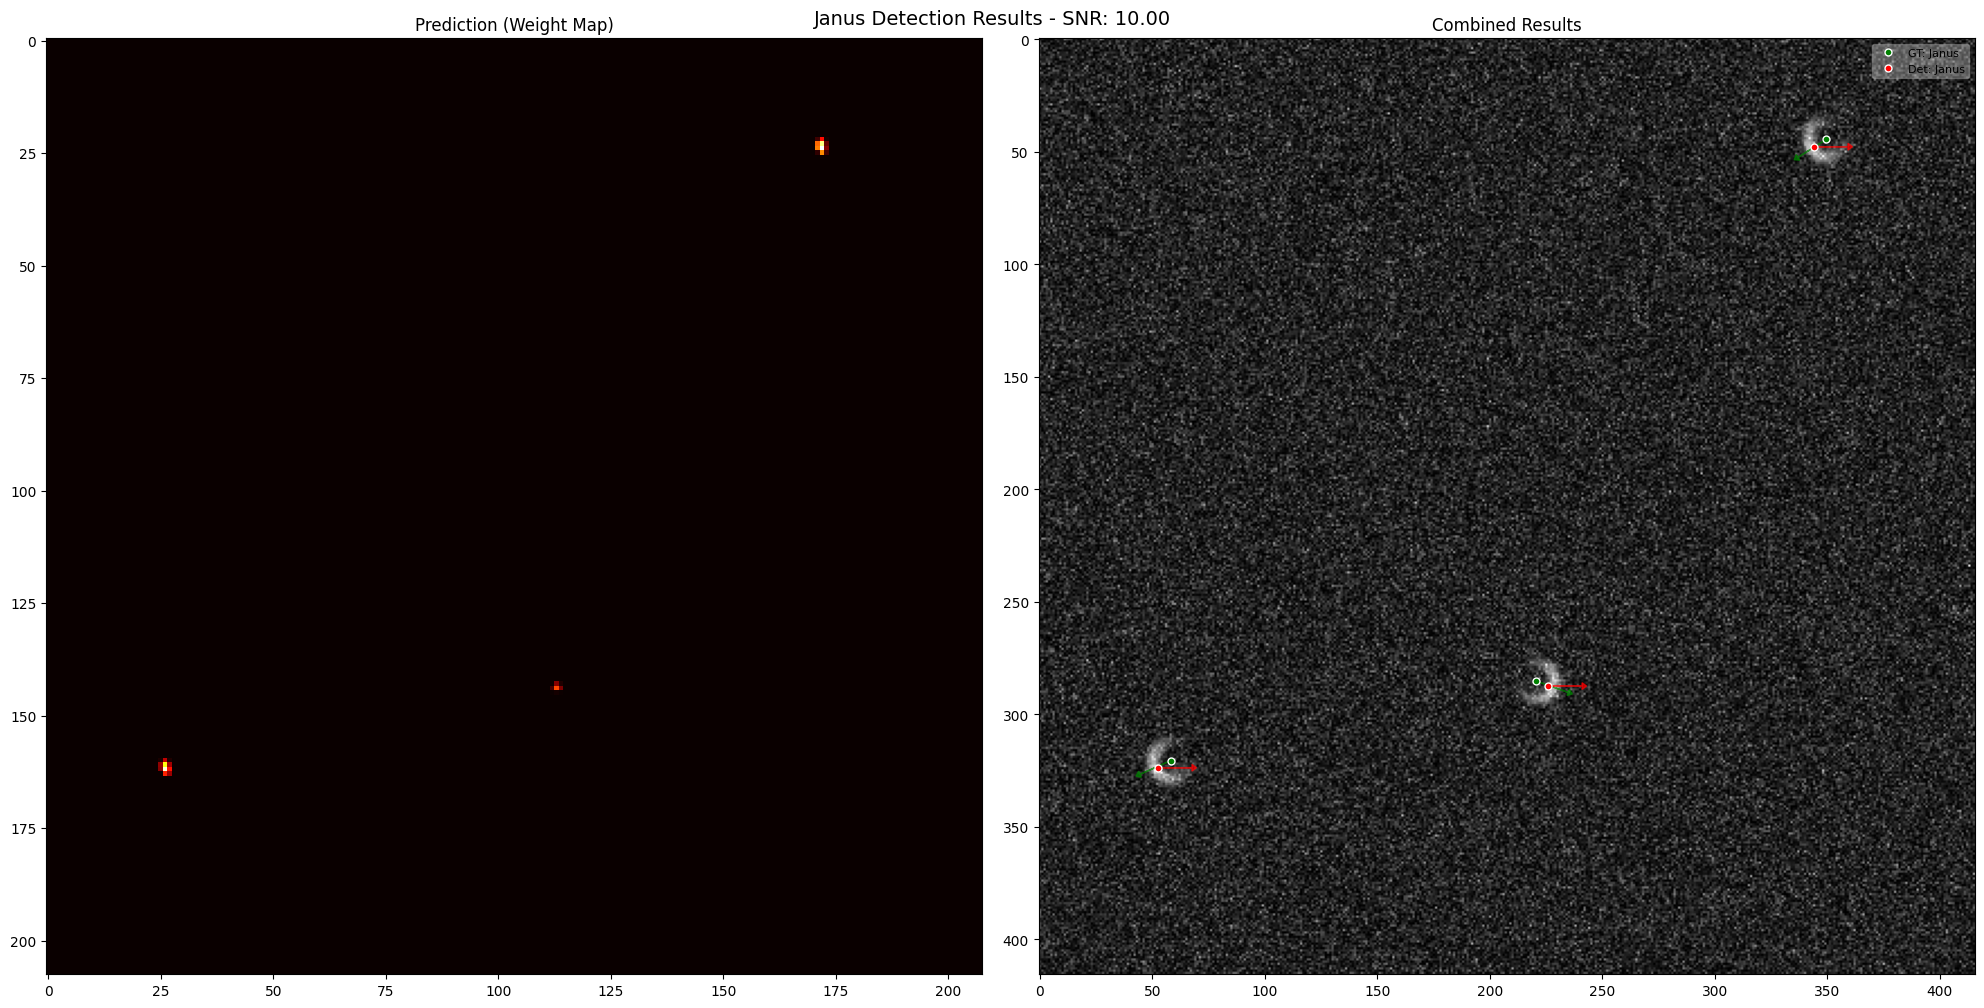

In [6]:
results = detect_particles(model, image, config, 'Janus')
detections, prediction, detection_labels, model_output, detection_orientations = results

# Visualize results
visualize_detection_results(
    image, 
    gt_bboxes, 
    detections, 
    prediction,
    title="Janus Detection Results",
    snr=snr,
    gt_labels=gt_labels,
    detection_labels=detection_labels,
    model_output=model_output,
    gt_orientations=gt_orientations,
    detection_orientations=detection_orientations
)

In [7]:
i=1

In [8]:
def debug_estimate_janus_center(arc_x, arc_y, weights, search_radius=30):
    """Debug version of _estimate_janus_center that returns intermediate values"""
    h, w = weights.shape
    arc_x_int = int(np.clip(arc_x, 0, w - 1))
    arc_y_int = int(np.clip(arc_y, 0, h - 1))
    
    probe_radius = 1.5
    threshold_factor = 0.5
    
    local_window = int(search_radius)
    y_min = max(0, arc_y_int - local_window)
    y_max = min(h, arc_y_int + local_window + 1)
    x_min = max(0, arc_x_int - local_window)
    x_max = min(w, arc_x_int + local_window + 1)
    
    local_weights = weights[y_min:y_max, x_min:x_max]
    if local_weights.size == 0:
        return {
            'center': (arc_x, arc_y),
            'arc_point': (arc_x, arc_y),
            'probe_radius': probe_radius,
            'threshold': 0,
            'intersection_points': [],
            'selected_points': [],
            'local_window': (x_min, y_min, x_max, y_max),
            'success': False
        }
    
    threshold = local_weights.max() * threshold_factor
    
    y_coords, x_coords = np.mgrid[y_min:y_max, x_min:x_max]
    distances_from_arc = np.sqrt((x_coords - arc_x)**2 + (y_coords - arc_y)**2)
    
    on_probe_circle = np.abs(distances_from_arc - probe_radius) < 0.5
    on_arc = local_weights > threshold
    
    intersection_mask = on_probe_circle & on_arc
    
    if intersection_mask.sum() < 2:
        probe_radius = 1.5
        on_probe_circle = np.abs(distances_from_arc - probe_radius) < 0.5
        intersection_mask = on_probe_circle & on_arc
    
    intersection_y = y_coords[intersection_mask]
    intersection_x = x_coords[intersection_mask]
    intersection_weights = local_weights[intersection_mask]
    
    all_intersections = list(zip(intersection_x, intersection_y, intersection_weights))
    
    if intersection_mask.sum() < 2:
        return {
            'center': (arc_x, arc_y),
            'arc_point': (arc_x, arc_y),
            'probe_radius': probe_radius,
            'threshold': threshold,
            'intersection_points': all_intersections,
            'selected_points': [],
            'local_window': (x_min, y_min, x_max, y_max),
            'success': False
        }
    
    sorted_indices = np.argsort(intersection_weights)[::-1]
    top_points = sorted_indices[:min(10, len(sorted_indices))]
    
    if len(top_points) < 2:
        return {
            'center': (arc_x, arc_y),
            'arc_point': (arc_x, arc_y),
            'probe_radius': probe_radius,
            'threshold': threshold,
            'intersection_points': all_intersections,
            'selected_points': [],
            'local_window': (x_min, y_min, x_max, y_max),
            'success': False
        }
    
    best_points = []
    for idx in top_points:
        px, py = intersection_x[idx], intersection_y[idx]
        if len(best_points) == 0:
            best_points.append((px, py))
        else:
            min_dist = min([np.sqrt((px - bx)**2 + (py - by)**2) for bx, by in best_points])
            if min_dist > 1.0:
                best_points.append((px, py))
                if len(best_points) >= 2:
                    break
    
    if len(best_points) < 2:
        return {
            'center': (arc_x, arc_y),
            'arc_point': (arc_x, arc_y),
            'probe_radius': probe_radius,
            'threshold': threshold,
            'intersection_points': all_intersections,
            'selected_points': [],
            'local_window': (x_min, y_min, x_max, y_max),
            'success': False
        }
    
    x1, y1 = arc_x, arc_y
    x2, y2 = best_points[0]
    x3, y3 = best_points[1]
    
    d = 2 * (x1*(y2-y3) + x2*(y3-y1) + x3*(y1-y2))
    
    if abs(d) < 1e-6:
        return {
            'center': (arc_x, arc_y),
            'arc_point': (arc_x, arc_y),
            'probe_radius': probe_radius,
            'threshold': threshold,
            'intersection_points': all_intersections,
            'selected_points': [(x1, y1), (x2, y2), (x3, y3)],
            'local_window': (x_min, y_min, x_max, y_max),
            'success': False,
            'error': 'collinear_points'
        }
    
    ux = ((x1*x1 + y1*y1)*(y2-y3) + (x2*x2 + y2*y2)*(y3-y1) + (x3*x3 + y3*y3)*(y1-y2)) / d
    uy = ((x1*x1 + y1*y1)*(x3-x2) + (x2*x2 + y2*y2)*(x1-x3) + (x3*x3 + y3*y3)*(x2-x1)) / d
    
    center_x = np.clip(ux, 0, w - 1)
    center_y = np.clip(uy, 0, h - 1)
    
    return {
        'center': (center_x, center_y),
        'arc_point': (arc_x, arc_y),
        'probe_radius': probe_radius,
        'threshold': threshold,
        'intersection_points': all_intersections,
        'selected_points': [(x1, y1), (x2, y2), (x3, y3)],
        'local_window': (x_min, y_min, x_max, y_max),
        'success': True
    }


In [9]:
# Get raw detections (arc points) and weight map
# Ensure image is 2D grayscale
debug_image = np.array(image)
if len(debug_image.shape) == 3:
    if debug_image.shape[-1] == 3:
        debug_image = np.dot(debug_image[..., :3], [0.299, 0.587, 0.114])
    elif debug_image.shape[0] == 3:
        debug_image = np.dot(debug_image[:3].transpose(1, 2, 0), [0.299, 0.587, 0.114])
    elif debug_image.shape[-1] == 1:
        debug_image = debug_image[..., 0]
    elif debug_image.shape[0] == 1:
        debug_image = debug_image[0]
elif len(debug_image.shape) > 3:
    if debug_image.shape[1] == 3:
        debug_image = np.dot(debug_image[0].transpose(1, 2, 0), [0.299, 0.587, 0.114])
    else:
        debug_image = debug_image[0, 0] if len(debug_image.shape) == 4 else debug_image[0]

if len(debug_image.shape) != 2:
    raise ValueError(f"Image must be 2D after processing, got shape {debug_image.shape}")

# Prepare image tensor: (H, W) -> (1, 1, H, W)
debug_image_tensor = torch.from_numpy(debug_image).unsqueeze(0).unsqueeze(0).float()

with torch.no_grad():
    model_output = model(debug_image_tensor)
    y_pred, weights_tensor = model_output[:, :-1], model_output[:, -1:]
    
weights_np = weights_tensor[0, 0].detach().cpu().numpy()
h, w = weights_np.shape

# Get detections without center correction
raw_detections = model.detect(
    debug_image_tensor,
    alpha=0.8,#config.get('alpha', 0.2),
    beta=0.2,#config.get('beta', 0.8),
    mode=config.get('mode', "constant"),
    cutoff=0.1,#config.get('cutoff', 0.2),
    particle_type='Janus',
    compute_center=False
)[0]

print(f"Found {len(raw_detections)} raw detections (arc points)")
print(f"Weight map shape: {weights_np.shape}")
print(f"Image shape: {debug_image.shape}")
print(f"Image tensor shape: {debug_image_tensor.shape}")

# Use first detection for debugging
if len(raw_detections) > 0:
    arc_y, arc_x = raw_detections[i, :2]
    print(f"\nDebugging first detection:")
    print(f"Arc point (A): ({arc_x:.2f}, {arc_y:.2f})")
    
    # Get ground truth center if available
    if len(gt_bboxes) > 0:
        gt_center = gt_bboxes[0]
        print(f"GT center: ({gt_center[0]:.2f}, {gt_center[1]:.2f})")
        gt_dist = np.sqrt((arc_x - gt_center[0])**2 + (arc_y - gt_center[1])**2)
        print(f"Distance from arc to GT center: {gt_dist:.2f} px")
else:
    print("No detections found!")


Found 3 raw detections (arc points)
Weight map shape: (208, 208)
Image shape: (416, 416)
Image tensor shape: torch.Size([1, 1, 416, 416])

Debugging first detection:
Arc point (A): (226.04, 287.40)
GT center: (220.71, 285.19)
Distance from arc to GT center: 5.77 px


In [10]:
# Debug the center estimation
if len(raw_detections) > 0:
    debug_result = debug_estimate_janus_center(arc_x, arc_y, weights_np, search_radius=30)
    
    print("Debug Results:")
    print(f"Success: {debug_result['success']}")
    print(f"Arc point (A): {debug_result['arc_point']}")
    print(f"Estimated center (O): {debug_result['center']}")
    print(f"Probe radius: {debug_result['probe_radius']:.2f} px")
    print(f"Weight threshold: {debug_result['threshold']:.4f}")
    print(f"Intersection points found: {len(debug_result['intersection_points'])}")
    print(f"Selected points (A, B, C): {len(debug_result['selected_points'])}")
    
    if debug_result['success']:
        center_x, center_y = debug_result['center']
        dist_from_arc = np.sqrt((center_x - arc_x)**2 + (center_y - arc_y)**2)
        print(f"Distance from arc to estimated center: {dist_from_arc:.2f} px")
        
        if len(gt_bboxes) > 0:
            gt_center = gt_bboxes[0]
            error = np.sqrt((center_x - gt_center[0])**2 + (center_y - gt_center[1])**2)
            print(f"Error from GT center: {error:.2f} px")
            
            # Compute orientation
            dx = arc_x - center_x
            dy = arc_y - center_y
            orientation = np.arctan2(dy, dx) / (2 * np.pi)
            print(f"Estimated orientation: {orientation:.4f} ({orientation * 360:.1f}°)")
            
            if gt_orientations and len(gt_orientations) > 0:
                gt_orient = gt_orientations[0]
                orient_error = min(abs(orientation - gt_orient), abs(orientation - gt_orient + 1), abs(orientation - gt_orient - 1))
                print(f"GT orientation: {gt_orient:.4f} ({gt_orient * 360:.1f}°)")
                print(f"Orientation error: {orient_error:.4f} ({orient_error * 360:.1f}°)")
    
    if 'error' in debug_result:
        print(f"Error: {debug_result['error']}")


Debug Results:
Success: False
Arc point (A): (np.float64(226.0423126220703), np.float64(287.4001159667969))
Estimated center (O): (np.float64(226.0423126220703), np.float64(287.4001159667969))
Probe radius: 1.50 px
Weight threshold: 0.0000
Intersection points found: 0
Selected points (A, B, C): 0


In [11]:
# Visualize the 3-point circle method
try:
    has_debug_result = debug_result['success']
except (NameError, KeyError):
    has_debug_result = False

if len(raw_detections) > 0 and has_debug_result:
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    x_min, y_min, x_max, y_max = debug_result['local_window']
    local_image = debug_image[y_min:y_max, x_min:x_max]
    local_weights = weights_np[y_min:y_max, x_min:x_max]
    
    # Plot 1: Weight map with probe circle
    axes[0].imshow(local_weights, cmap='hot', origin='upper')
    axes[0].set_title(f"Weight Map (threshold={debug_result['threshold']:.3f})")
    
    # Draw probe circle
    probe_radius = debug_result['probe_radius']
    theta = np.linspace(0, 2*np.pi, 100)
    circle_x = (arc_x - x_min) + probe_radius * np.cos(theta)
    circle_y = (arc_y - y_min) + probe_radius * np.sin(theta)
    axes[0].plot(circle_x, circle_y, 'b-', linewidth=2, label=f'Probe circle (r={probe_radius:.1f})')
    
    # Mark arc point
    axes[0].plot(arc_x - x_min, arc_y - y_min, 'go', markersize=10, markeredgecolor='white', markeredgewidth=2, label='Arc point (A)')
    
    # Mark all intersections
    if debug_result['intersection_points']:
        int_x = [p[0] - x_min for p in debug_result['intersection_points']]
        int_y = [p[1] - y_min for p in debug_result['intersection_points']]
        axes[0].plot(int_x, int_y, 'yo', markersize=6, alpha=0.6, label='Intersections')
    
    axes[0].legend(loc='upper right', fontsize=8)
    axes[0].grid(True, alpha=0.3)
    
    # Plot 2: Image with 3 points and computed center
    axes[1].imshow(local_image, cmap='gray', origin='upper')
    axes[1].set_title("3-Point Circle Method")
    
    # Draw the 3 points
    if len(debug_result['selected_points']) == 3:
        A, B, C = debug_result['selected_points']
        axes[1].plot(A[0] - x_min, A[1] - y_min, 'go', markersize=12, markeredgecolor='white', markeredgewidth=2, label='Point A (arc)')
        axes[1].plot(B[0] - x_min, B[1] - y_min, 'bo', markersize=10, markeredgecolor='white', markeredgewidth=2, label='Point B')
        axes[1].plot(C[0] - x_min, C[1] - y_min, 'co', markersize=10, markeredgecolor='white', markeredgewidth=2, label='Point C')
        
        # Draw lines connecting points
        axes[1].plot([A[0] - x_min, B[0] - x_min], [A[1] - y_min, B[1] - y_min], 'b--', alpha=0.5, linewidth=1)
        axes[1].plot([A[0] - x_min, C[0] - x_min], [A[1] - y_min, C[1] - y_min], 'c--', alpha=0.5, linewidth=1)
        axes[1].plot([B[0] - x_min, C[0] - x_min], [B[1] - y_min, C[1] - y_min], 'm--', alpha=0.5, linewidth=1)
        
        # Draw computed circle
        center_x, center_y = debug_result['center']
        radius = np.sqrt((A[0] - center_x)**2 + (A[1] - center_y)**2)
        circle_x = (center_x - x_min) + radius * np.cos(theta)
        circle_y = (center_y - y_min) + radius * np.sin(theta)
        axes[1].plot(circle_x, circle_y, 'r-', linewidth=2, alpha=0.7, label='Computed circle')
        
        # Mark computed center
        axes[1].plot(center_x - x_min, center_y - y_min, 'r*', markersize=15, markeredgecolor='white', markeredgewidth=2, label='Center (O)')
        
        # Draw orientation arrow (OA)
        dx = A[0] - center_x
        dy = A[1] - center_y
        axes[1].arrow(center_x - x_min, center_y - y_min, dx, dy, 
                     head_width=3, head_length=2, fc='red', ec='red', alpha=0.8, linewidth=2, label='Orientation (OA)')
    
    # Mark GT center if available
    if len(gt_bboxes) > 0:
        gt_center = gt_bboxes[0]
        if x_min <= gt_center[0] < x_max and y_min <= gt_center[1] < y_max:
            axes[1].plot(gt_center[0] - x_min, gt_center[1] - y_min, 'g*', markersize=15, 
                        markeredgecolor='white', markeredgewidth=2, label='GT Center')
    
    axes[1].legend(loc='upper right', fontsize=8)
    axes[1].grid(True, alpha=0.3)
    
    # Plot 3: Full image view
    axes[2].imshow(debug_image, cmap='gray', origin='upper')
    axes[2].set_title("Full Image View")
    
    # Mark arc point
    axes[2].plot(arc_x, arc_y, 'go', markersize=8, markeredgecolor='white', markeredgewidth=1, label='Arc point')
    
    # Mark computed center
    center_x, center_y = debug_result['center']
    axes[2].plot(center_x, center_y, 'r*', markersize=12, markeredgecolor='white', markeredgewidth=1, label='Estimated center')
    
    # Draw orientation arrow
    dx = arc_x - center_x
    dy = arc_y - center_y
    axes[2].arrow(center_x, center_y, dx, dy, 
                 head_width=5, head_length=3, fc='red', ec='red', alpha=0.8, linewidth=2, label='Orientation')
    
    # Mark GT center and orientation
    if len(gt_bboxes) > 0:
        gt_center = gt_bboxes[0]
        axes[2].plot(gt_center[0], gt_center[1], 'g*', markersize=12, markeredgecolor='white', markeredgewidth=1, label='GT center')
        
        if gt_orientations and len(gt_orientations) > 0:
            gt_orient = gt_orientations[0] * 2 * np.pi
            arrow_length = 20
            dx_gt = arrow_length * np.cos(gt_orient)
            dy_gt = -arrow_length * np.sin(gt_orient)
            axes[2].arrow(gt_center[0], gt_center[1], dx_gt, dy_gt, 
                         head_width=4, head_length=2, fc='green', ec='green', alpha=0.6, linewidth=1.5, label='GT orientation')
    
    axes[2].legend(loc='upper right', fontsize=8)
    axes[2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print summary
    if len(gt_bboxes) > 0:
        error = np.sqrt((center_x - gt_center[0])**2 + (center_y - gt_center[1])**2)
        print(f"\nSummary:")
        print(f"  Center estimation error: {error:.2f} px")
        if gt_orientations and len(gt_orientations) > 0:
            est_orient = np.arctan2(dy, dx) / (2 * np.pi)
            orient_error = min(abs(est_orient - gt_orientations[0]), 
                             abs(est_orient - gt_orientations[0] + 1), 
                             abs(est_orient - gt_orientations[0] - 1))
            print(f"  Orientation error: {orient_error * 360:.1f}°")
else:
    print("Cannot visualize: center estimation failed or no detections")


Cannot visualize: center estimation failed or no detections


In [12]:
# Test all detections and compare with ground truth
if len(raw_detections) > 0 and len(gt_bboxes) > 0:
    print("Testing all detections:\n")
    
    errors = []
    orient_errors = []
    
    for i, detection in enumerate(raw_detections[:min(5, len(raw_detections))]):
        arc_y, arc_x = detection[:2]
        debug_result = debug_estimate_janus_center(arc_x, arc_y, weights_np, search_radius=30)
        
        if debug_result['success']:
            center_x, center_y = debug_result['center']
            
            # Find closest GT center
            if len(gt_bboxes) > i:
                gt_center = gt_bboxes[i]
                error = np.sqrt((center_x - gt_center[0])**2 + (center_y - gt_center[1])**2)
                errors.append(error)
                
                # Compute orientation
                dx = arc_x - center_x
                dy = arc_y - center_y
                est_orient = np.arctan2(dy, dx) / (2 * np.pi)
                
                if gt_orientations and i < len(gt_orientations):
                    gt_orient = gt_orientations[i]
                    orient_error = min(abs(est_orient - gt_orient), 
                                     abs(est_orient - gt_orient + 1), 
                                     abs(est_orient - gt_orient - 1))
                    orient_errors.append(orient_error)
                    
                    print(f"Detection {i+1}:")
                    print(f"  Arc: ({arc_x:.1f}, {arc_y:.1f})")
                    print(f"  Center: ({center_x:.1f}, {center_y:.1f})")
                    print(f"  GT Center: ({gt_center[0]:.1f}, {gt_center[1]:.1f})")
                    print(f"  Center error: {error:.2f} px")
                    print(f"  Orientation: {est_orient*360:.1f}° (GT: {gt_orient*360:.1f}°)")
                    print(f"  Orientation error: {orient_error*360:.1f}°")
                    print()
                else:
                    print(f"Detection {i+1}: Center error: {error:.2f} px")
            else:
                print(f"Detection {i+1}: No GT available")
        else:
            print(f"Detection {i+1}: Center estimation failed")
    
    if errors:
        print(f"\nStatistics:")
        print(f"  Mean center error: {np.mean(errors):.2f} px")
        print(f"  Std center error: {np.std(errors):.2f} px")
        print(f"  Max center error: {np.max(errors):.2f} px")
        
    if orient_errors:
        print(f"  Mean orientation error: {np.mean(orient_errors)*360:.1f}°")
        print(f"  Std orientation error: {np.std(orient_errors)*360:.1f}°")
        print(f"  Max orientation error: {np.max(orient_errors)*360:.1f}°")


Testing all detections:

Detection 1: Center estimation failed
Detection 2: Center estimation failed
Detection 3: Center estimation failed
